In [1]:
import numpy as np
from scipy.linalg import eigh
from viga import Viga
import plotfrecs as pf
import pdb
import matplotlib.pyplot as plt
import mefmods as mef
plt.style.use('default')
plt.rc('figure', figsize=(12,8))
plt.rc('font', size=22)
modo = 'trans'
modo_name = 'Transversal'
glxn = 2
#interpolators = [mef.NL1DA, mef.NL1DB]
interpolators = [mef.NT1, mef.NT2, mef.NT3, mef.NT4]

Iniciamos el objeto Viga.

In [2]:
V = Viga(1, 210e9, 10e-4, 7850, 10e-8)
#V.mesh(3, 'long')

In [3]:
# Estudio de convergencia, modos transversales lump vs consistentes
maxmode = 6
nmax = 15
w_cons, d_cons = V.converge_study(nmax, maxmode, modo)
# solucion de muchos modos

In [4]:
V.MN.shape

(16, 2)

In [5]:
V.mesh(100, modo)
wv, dv = V.solvemods(V.K, V.M)
# dv = dv[::2, :] / dv[-2, :]
xv = np.linspace(0, 1, 101)
w_lump, d_lump = V.converge_study(nmax, maxmode,  modo+'_lump')

In [6]:
MODES = [d_cons, d_lump]
labels=('consistentes', 'concentradadas')

In [7]:
import matplotlib.lines as mlines

In [8]:
modes = [1,2,3,4]

In [9]:
x, y, xx, yy = V.InterpolateAllElements(d_cons, modes, interpolators=interpolators, _glxn= glxn)

Text(0.5, 1.05, 'masas consistentes')

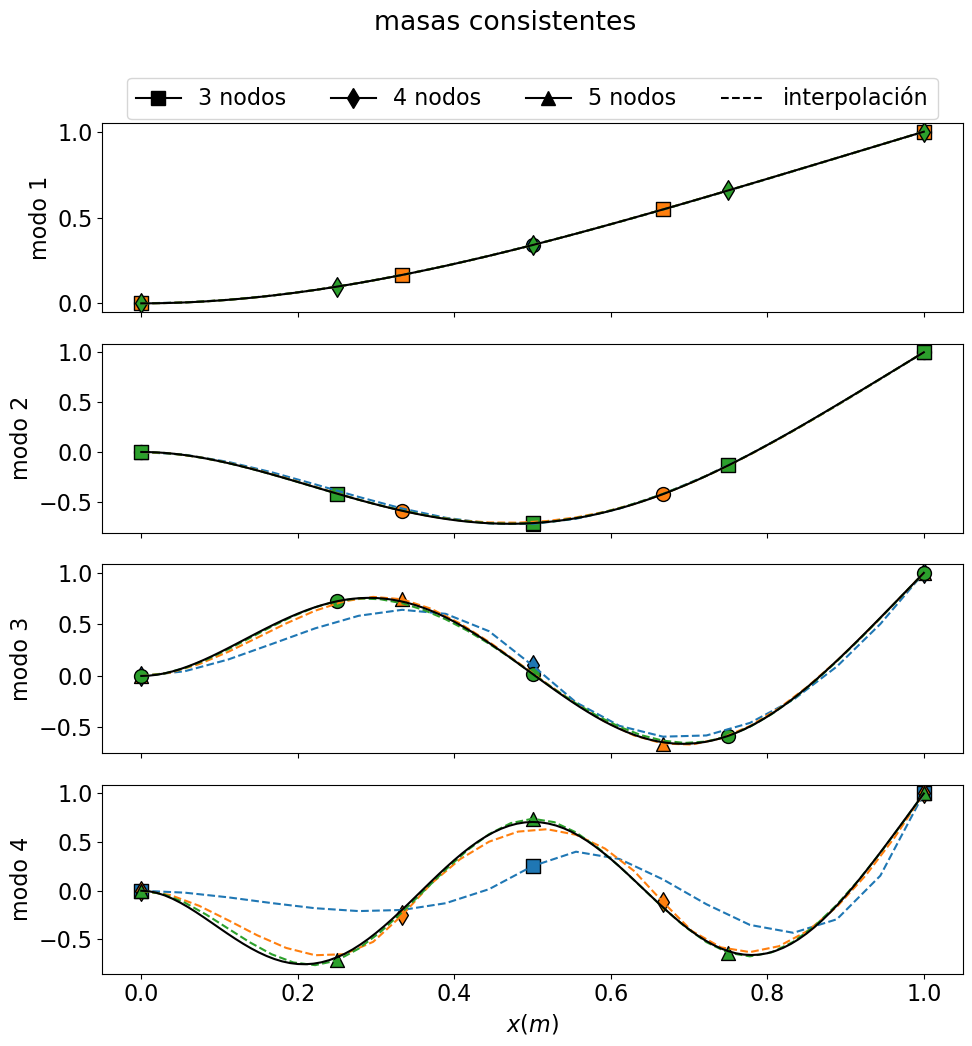

In [10]:
fig, ax = V.plot_modes(modes, x,y,xx,yy)
for m, tax in enumerate(ax):
    axes = tax.plot(xv, dv[::glxn,m]/dv[-glxn,m], 'k')
fig.suptitle('masas consistentes', y=1.05)


In [11]:
xt, yt, xxt, yyt = V.InterpolateAllElements(d_lump, modes, interpolators=interpolators, _glxn= glxn)

Text(0.5, 1.05, 'masas concentradas')

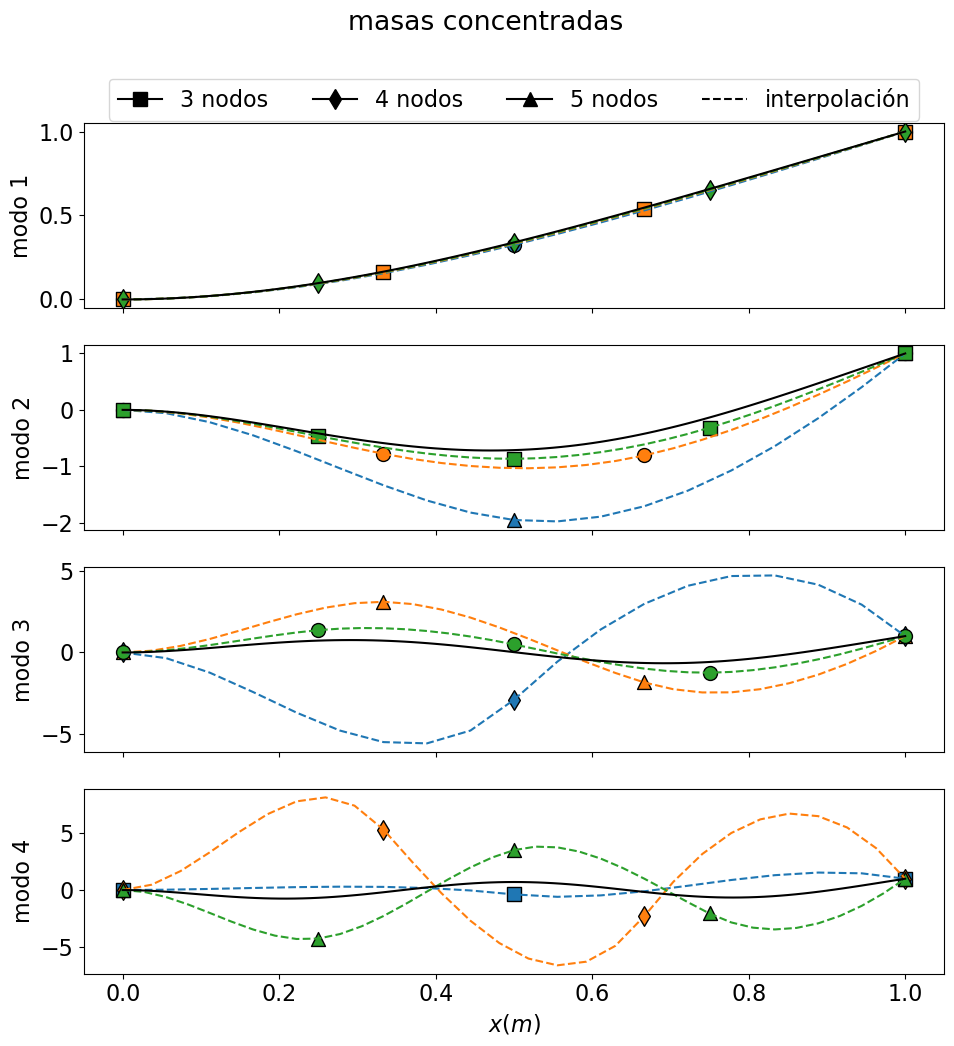

In [12]:
fig, ax = V.plot_modes(modes, xt,yt,xxt,yyt)
fig.suptitle
for m, tax in enumerate(ax):
    tax.plot(xv, dv[::glxn,m]/dv[-glxn,m], 'k')
fig.suptitle('masas concentradas', y=1.05)

/home/mariano/modelizacion/SolucionesProblemas/Guia4-MEF-dt/Guia4-python/Ejercicio1/plotfrecs.py:34: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(lin,
/home/mariano/modelizacion/SolucionesProblemas/Guia4-MEF-dt/Guia4-python/Ejercicio1/plotfrecs.py:39: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


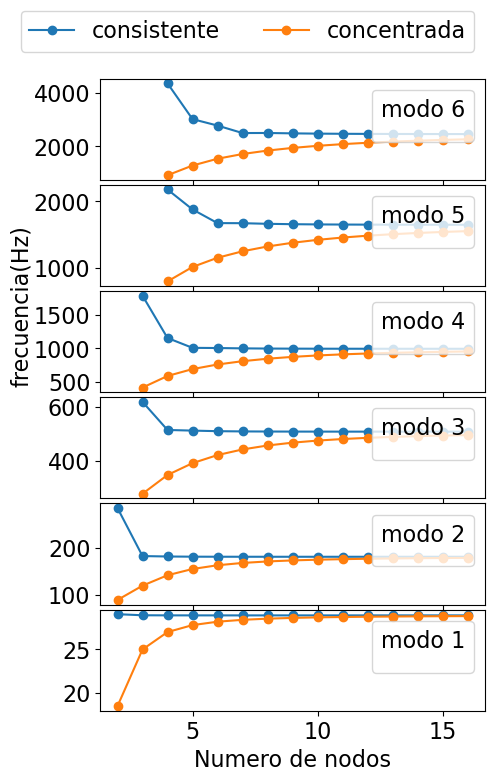

In [13]:
ws = [w_cons, w_lump]
cases = ['consistente', 'concentrada']
name='transversal'
pf.plotfrecs(ws, cases, name)

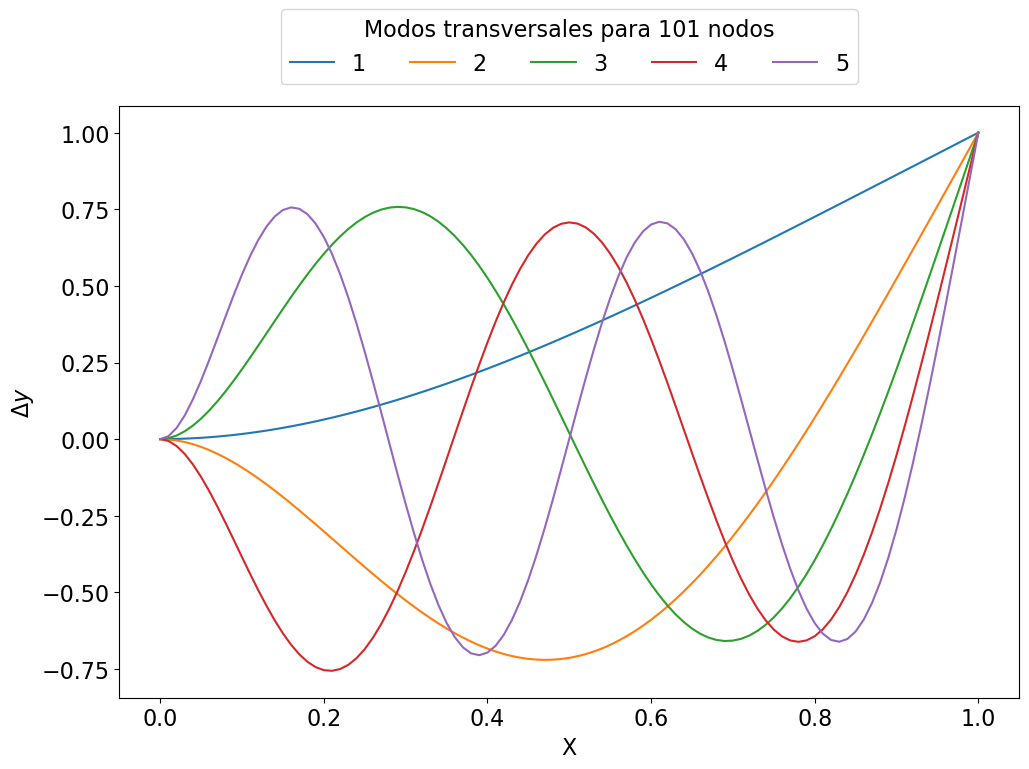

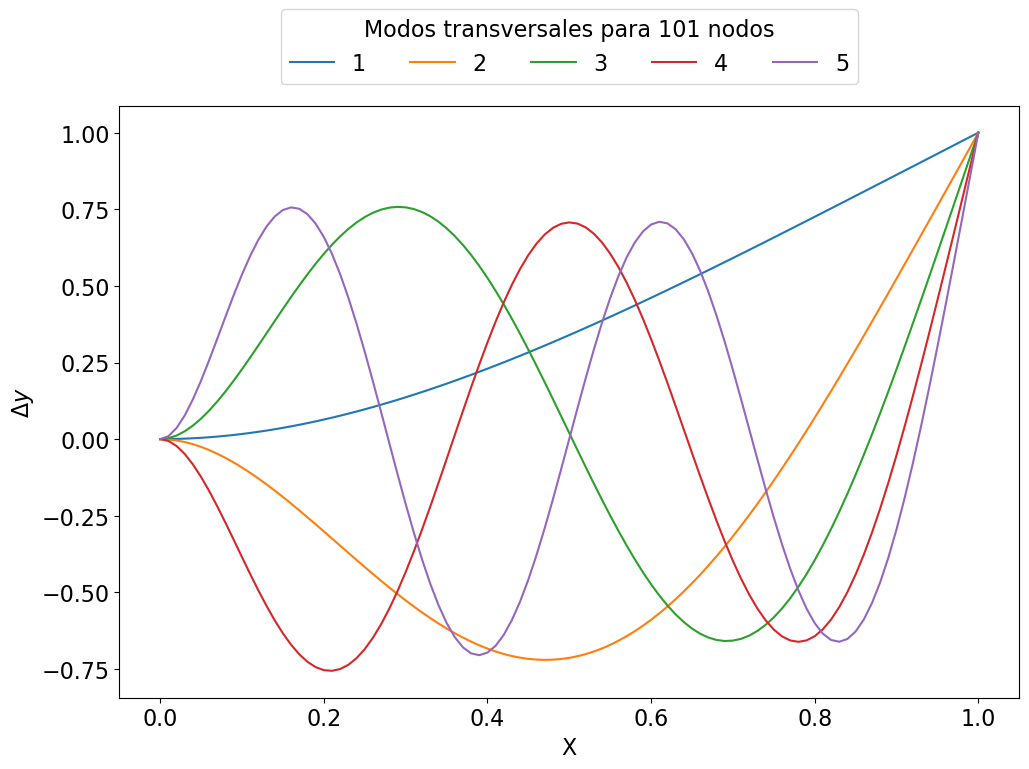

In [14]:
# los primeros 5 modos trans
pf.allmodesplot(dv[:,:5], 'transversales', fig_size=(4, 10))

In [21]:
import gmsh

ModuleNotFoundError: No module named 'gmsh'

In [36]:
gmsh.initialize()
modelname = 'ModosTransversales'
gmsh.model.add(modelname)
MN = np.hstack([V.MN, np.zeros([len(V.MN), 1])])
nodetags = np.linspace(1, len(V.MN), len(V.MN)).astype(int)
elementtags = np.linspace(1, len(V.MC)+1, len(V.MC)).astype(int)
Points = []
Points.append(gmsh.model.geo.addPoint(*np.append(MN[0],[1])))
Points.append(gmsh.model.geo.addPoint(*np.append(MN[-1],[1])))
L = gmsh.model.geo.addLine(*Points)
gmsh.model.geo.synchronize()
group = gmsh.model.addPhysicalGroup(1, [L])
gmsh.model.mesh.addNodes(1, L, nodetags, MN.ravel())
gmsh.model.mesh.addElements(1, L, [1], [elementtags], [V.MC.ravel()+1])
gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)

imodo = 3

Info    : Increasing process stack size (8192 kB < 16 MB)


In [39]:
dv

array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [-1.2492e-04, -7.7391e-04, -2.1445e-03, ...,  3.0856e-02, -1.5457e-02, -2.7084e-18],
       ...,
       [-9.8259e-01,  3.4126e+00, -5.6022e+00, ...,  1.5431e+01,  7.8129e+00, -3.2170e+03],
       [-7.1383e-01,  7.1383e-01, -7.1383e-01, ...,  9.8132e-02,  4.9268e-02, -8.6501e+00],
       [-9.8259e-01,  3.4127e+00, -5.6026e+00, ...,  9.0885e+01,  4.5656e+01, -8.7271e+03]])

In [43]:
thisview = gmsh.view.add(f'modo{imodo}')
mode = dv[::glxn,imodo-1].reshape(-1,1)
zeros = np.zeros((len(nodetags), 1))

In [47]:
zeros.shape

(16, 1)

In [45]:
omega = wv[imodo-1]
T = 2*np.pi / (omega)
ts = np.linspace(0, T, 10)
#fig,ax = plt.subplots(1,len(ts), figsize=(15,5), sharey=True)

for i, t in enumerate(ts[:-1]):
    D = np.hstack([zeros, mode*np.sin(omega*t), zeros])
    gmsh.view.addModelData(
        modo1, i, modelname,'NodeData', nodetags, D, t, numComponents=3 )

gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)

gmsh.write(f'Modo{imodo}.msh')

gmsh.fltk.run()

gmsh.finalize()

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 16 and the array at index 1 has size 101